# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



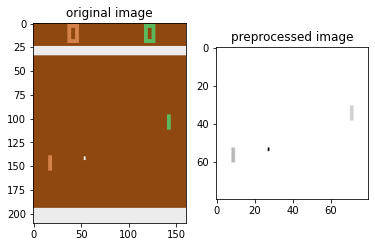

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))


# run your own policy!
policy=Policy().to(device)
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

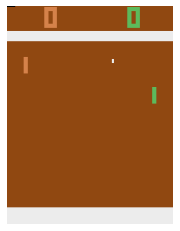

In [15]:
from IPython.display import HTML
fanim = pong_utils.play(env, policy, time=20)
HTML(fanim.to_jshtml())
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [16]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    discounts = [discount**i for i in range(len(rewards))]
    # rewards is a list of lists. Each entry is a timestep, for example rewards[0] is rewards in timestep 0.
    # rewards[0] is also a list of size 4 (if there are 4 parallel workers), each entry is reward for that worker.
    discounted_rewards = [rewards[i]*discounts[i] for i in range(len(rewards))]
    discounted_rewards = np.asarray(discounted_rewards)
    
    # convert rewards to future rewards
    # because np.cumsum accumlates everything that was before index i (i-1, i-2,...)
    # and we want the opposite, to accumlate everything in the future we need to reverse the array
    discounted_rewards = np.flip(discounted_rewards, axis=0)
    cumulative_discounted_rewards = np.cumsum(discounted_rewards,axis=0)
    # Flip back
    cumulative_discounted_rewards = np.flip(cumulative_discounted_rewards, axis=0)
    
    # normalize rewards
    # average over n trajectories - get mean value for each timestep
    mean = np.mean(cumulative_discounted_rewards, axis=1)
    # std over n trajectories - get std value for each timestep
    std = np.std(cumulative_discounted_rewards, axis=1) + 1e-8
    
    cumulative_discounted_rewards = (cumulative_discounted_rewards - np.expand_dims(mean,-1)) /  np.expand_dims(std,-1)
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    cumulative_discounted_rewards = torch.tensor(cumulative_discounted_rewards, dtype=torch.float, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)

    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    ratio = new_probs/old_probs
    ratio_clipped = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    min_surrogate = torch.min(cumulative_discounted_rewards * ratio, cumulative_discounted_rewards * ratio_clipped)
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    # in this case new_probs and old_probs comes from the same distribution
    #return torch.mean(beta*entropy + cumulative_discounted_rewards * torch.log(new_probs))
    return torch.mean(beta*entropy + min_surrogate)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [17]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 600

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        #L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: -15.500000
[-15. -16. -17. -16. -13. -16. -15. -16.]


Episode: 40, score: -15.000000
[-16. -16. -16. -15. -16. -14. -14. -13.]


Episode: 60, score: -15.375000
[-16. -16. -14. -16. -16. -15. -16. -14.]


Episode: 80, score: -14.750000
[-16. -16. -13. -16. -16. -12. -17. -12.]


Episode: 100, score: -12.125000
[-10.  -9. -11. -10. -12. -15. -14. -16.]


Episode: 120, score: -14.750000
[-13. -16. -16. -15. -16. -15. -11. -16.]


Episode: 140, score: -12.125000
[-12.  -7. -14. -11. -14. -13. -10. -16.]


Episode: 160, score: -13.000000
[-16. -13. -10. -16. -12.  -9. -13. -15.]


Episode: 180, score: -10.125000
[ -9. -10.  -8. -12. -10. -10.  -7. -15.]


Episode: 200, score: -8.500000
[-10. -11. -13.  -5.  -9.  -3.  -8.  -9.]


Episode: 220, score: -7.125000
[-10.  -5.  -5.  -6. -11.  -4.  -9.  -7.]


Episode: 240, score: -6.125000
[ -8.  -8.  -4.  -4.  -4.  -2. -10.  -9.]


Episode: 260, score: -3.875000
[-6. -4. -3. -4. -8. -4. -1. -1.]


Episode: 280, score: -3.250000
[  0.   2.  -1.  -7.  -7.  -2.  -1. -10.]


Episode: 300, score: -3.000000
[-5. -5. -1. -3. -3.  1. -2. -6.]


Episode: 320, score: -1.250000
[ 0. -2. -1. -1. -1. -1. -3. -1.]


Episode: 340, score: -1.750000
[-1.  0. -2. -2. -6. -1. -1. -1.]


Episode: 360, score: -1.125000
[-3. -1.  0. -1. -1. -1. -1. -1.]


Episode: 380, score: -1.250000
[-1. -1. -1. -3. -1. -1. -1. -1.]


Episode: 400, score: -1.125000
[-1. -1. -1. -2. -1. -2. -1.  0.]


Episode: 420, score: 0.125000
[-2. -1.  0. -1.  3.  3. -1.  0.]


Episode: 440, score: 0.750000
[ 3. -3.  3.  3. -5. -1.  3.  3.]


Episode: 460, score: 2.750000
[ 4.  3.  5. -3.  3.  3.  3.  4.]


Episode: 480, score: 3.500000
[ 5.  5.  3.  5.  5.  5. -3.  3.]


Episode: 500, score: 4.625000
[5. 5. 5. 4. 5. 3. 5. 5.]


Episode: 520, score: 4.125000
[3. 5. 5. 5. 5. 5. 3. 2.]


Episode: 540, score: 4.750000
[5. 5. 5. 5. 5. 5. 3. 5.]


Episode: 560, score: 3.875000
[ 5.  5.  5.  5.  4. -3.  5.  5.]


Episode: 580, score: 4.750000
[5. 5. 5. 5. 5. 5. 5. 3.]


Episode: 600, score: 4.500000
[5. 5. 1. 5. 5. 5. 5. 5.]


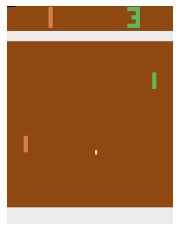

In [19]:
from IPython.display import HTML
fanim = pong_utils.play(env, policy, time=200) 
HTML(fanim.to_jshtml())

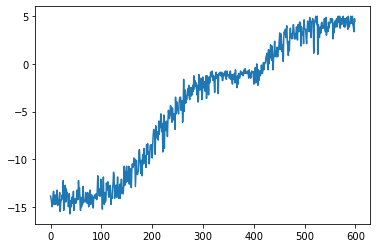

In [21]:
plt.plot(mean_rewards)

In [20]:
# save your policy!
torch.save(policy, 'PPO_shirel.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

/home/shirel/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
